<a href="https://colab.research.google.com/github/himanshu-kr-jha/formerPose_implementation/blob/main/FormerPose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L || true
!pip -q install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install einops timm open3d transforms3d pyyaml tqdm opencv-python scipy
!pip install torch torchvision -q
!pip install opencv-python scipy gdown matplotlib tqdm -q
print("✅ All packages installed!")

GPU 0: Tesla T4 (UUID: GPU-a06709a0-0032-e36e-da12-393d54ee431c)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 133.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.6 MB/s eta 0:00:00
✅ All packages installed!


In [2]:
import os, cv2, torch, torch.nn as nn
import numpy as np
from scipy.spatial.transform import Rotation as R
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import gdown, zipfile
import os, math, random, yaml, time, glob
from pathlib import Path
import numpy as np
import open3d as o3d
import cv2
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from einops import rearrange, repeat
import transforms3d as t3d
from scipy.spatial import cKDTree
torch.backends.cudnn.benchmark = True

def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(42)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# Cell 2: Download and unzip LINEMOD from Google Drive
import gdown
import zipfile
import os

# Google Drive direct download
file_id = "1g5JXJsTBbj5QZTcTsXI_LQm45Bjgom1s"
output = "linemod.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

import tarfile

tar_path = "linemod.zip"
extract_folder = "LINEMOD"

if tarfile.is_tarfile(tar_path):
    with tarfile.open(tar_path, "r:gz") as tar_ref:
        tar_ref.extractall(extract_folder)
    print("✅ Extracted with tarfile to", extract_folder)
else:
    print("File is not a tar file; check upload/download or rename as .tar.gz if needed.")

Downloading...
From (original): https://drive.google.com/uc?id=1g5JXJsTBbj5QZTcTsXI_LQm45Bjgom1s
From (redirected): https://drive.google.com/uc?id=1g5JXJsTBbj5QZTcTsXI_LQm45Bjgom1s&confirm=t&uuid=e28938b7-a87c-485b-b330-80234f30885d
To: /content/linemod.zip
100%|██████████| 1.98G/1.98G [00:31<00:00, 63.2MB/s]
/tmp/ipython-input-1896244440.py:18: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall(extract_folder)


✅ Extracted with tarfile to LINEMOD


In [4]:
CFG = {
    "data_root": "/content/data",   # TODO: set to LineMOD or YCB-Video root
    "dataset": "ycbv",              # "linemod" or "ycbv"
    "batch_size": 8,
    "num_workers": 4,
    "epochs": 1,
    "lr": 2e-4,
    "wd": 1e-4,
    "img_size": 480,                # keep reasonably sized
    "pc_n": 1024,                   # point count per sample
    "rgb_scales": [1, 2, 4, 8],     # for MRSA downsample factors
    "hidden": 256,
    "dropkey_p": 0.1,               # DropKey prob (on keys) per FormerPose
    "save_dir": "/content/ckpts",
    "symmetry_ids": set([24,36,51,52,61]),  # YCB symmetric example IDs
    "model_points": "/content/model_points",# npy files per object (Nx3)
}
CFG["data_root"] = "/content/LINEMOD/LINEMOD"   # <- where your unpacked data lives
CFG["dataset"]   = "linemod"
CFG["img_size"]  = 256
CFG["pc_n"]      = 1000

# OOM-safe defaults (you can later scale up)
CFG.update({
    "img_size": 192,          # was 256
    "pc_n": 512,              # was 1000
    "batch_size": 2,          # start small
    "num_workers": 2,         # matches Colab suggestion
    "hidden": 96,             # was 128
    # "hidden": 128,             # was 128
    "rgb_scales": [8,4,2,1],  # keep
    "dropkey_p": 0.1,
})
import torch
torch.set_float32_matmul_precision("medium")
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


os.makedirs(CFG["save_dir"], exist_ok=True)


In [5]:
print(CFG)

{'data_root': '/content/LINEMOD/LINEMOD', 'dataset': 'linemod', 'batch_size': 2, 'num_workers': 2, 'epochs': 1, 'lr': 0.0002, 'wd': 0.0001, 'img_size': 192, 'pc_n': 512, 'rgb_scales': [8, 4, 2, 1], 'hidden': 96, 'dropkey_p': 0.1, 'save_dir': '/content/ckpts', 'symmetry_ids': {36, 51, 52, 24, 61}, 'model_points': '/content/model_points'}


In [6]:
def se3_from_r_t(R, t):
    T = np.eye(4, dtype=np.float32)
    T[:3,:3] = R
    T[:3, 3] = t
    return T

def quat_to_mat(q):
    q = q / (np.linalg.norm(q) + 1e-8)
    return t3d.quaternions.quat2mat([q[0], q[1], q[2], q[3]])

def mat_to_quat(R):
    q = t3d.quaternions.mat2quat(R)
    return np.array([q[0], q[1], q[2], q[3]], dtype=np.float32)

def add_error(model_pts, R_pred, t_pred, R_gt, t_gt):
    P_pred = (R_pred @ model_pts.T).T + t_pred[None,:]
    P_gt   = (R_gt   @ model_pts.T).T + t_gt[None,:]
    return np.mean(np.linalg.norm(P_pred - P_gt, axis=1))

def add_s_error(model_pts, R_pred, t_pred, R_gt, t_gt):
    P_pred = (R_pred @ model_pts.T).T + t_pred[None,:]
    P_gt   = (R_gt   @ model_pts.T).T + t_gt[None,:]
    tree = cKDTree(P_gt)
    d, _ = tree.query(P_pred, k=1)
    return np.mean(d)

def batch_add_like(pred_R, pred_t, R_gt, t_gt, model_pts, symmetric=False):
    errs = []
    for i in range(pred_R.shape[0]):
        if symmetric:
            e = add_s_error(model_pts, pred_R[i], pred_t[i], R_gt[i], t_gt[i])
        else:
            e = add_error(model_pts, pred_R[i], pred_t[i], R_gt[i], t_gt[i])
        errs.append(e)
    return np.array(errs, dtype=np.float32)

def rot6d_to_mat(r6):
    # Zhou et al. 6D rot representation -> rotation matrix
    a1 = r6[..., 0:3]
    a2 = r6[..., 3:6]
    b1 = F.normalize(a1, dim=-1)
    b2 = F.normalize(a2 - (b1 * a2).sum(-1, keepdim=True) * b1, dim=-1)
    b3 = torch.cross(b1, b2, dim=-1)
    R = torch.stack([b1, b2, b3], dim=-1)
    return R


In [7]:
def backproject_depth(depth, K, valid_mask=None):
    """
    depth: (H,W) in meters
    K: (3,3)
    returns: (N,3) XYZ in camera coord
    """
    H, W = depth.shape
    vs, us = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    if valid_mask is None:
        valid_mask = (depth > 0)
    us = us[valid_mask]; vs = vs[valid_mask]; ds = depth[valid_mask]
    fx, fy = K[0,0], K[1,1]; cx, cy = K[0,2], K[1,2]
    X = (us - cx) * ds / fx
    Y = (vs - cy) * ds / fy
    Z = ds
    P = np.stack([X, Y, Z], axis=-1)
    return P


In [8]:
# Cell 6 — LINEMOD Dataset (drop-in replacement for my stub)
import cv2, numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R

class LinemodDataset(Dataset):
    """
    LINEMOD Dataset for 6D Pose Estimation
    Expects per-object folders containing JPEGImages/, mask/, pose/, and dense_pts.txt or {obj}.ply
    Produces keys aligned with the FormerPose training code: rgb, pc, R_gt, t_gt, obj_id
    """
    def __init__(self, linemod_dir, split='train', img_size=256, num_points=1000):
        self.root = Path(linemod_dir)
        self.img_size = img_size
        self.num_points = num_points
        self.samples = []
        self.model_points = {}

        all_dirs = [x for x in os.listdir(linemod_dir)
                    if os.path.isdir(os.path.join(linemod_dir, x))]
        exclude = ['posedb', 'renders', 'fuse']
        self.objects = [obj for obj in all_dirs if obj not in exclude]
        self.objects.sort()

        # name->int id (stable)
        self.obj2id = {name: i for i, name in enumerate(self.objects)}
        self.id2obj = {i: name for name, i in self.obj2id.items()}

        # symmetric set (LINEMOD)
        self.symmetric_set = set(['eggbox', 'glue'])

        print(f"\n{'='*70}")
        print(f"Loading {split.upper()} split from: {self.root}")
        print(f"{'='*70}")
        print(f"Objects: {', '.join(self.objects)}")

        self._load_model_points()
        for obj in self.objects:
            self.samples.extend(self._load_object_samples(obj, split))

        print(f"\n✅ Total samples loaded: {len(self.samples)}")
        print(f"{'='*70}\n")

    def _load_model_points(self):
        print("\nLoading model points:")
        for obj in self.objects:
            obj_dir = os.path.join(self.root, obj)

            dense_pts_file = os.path.join(obj_dir, "dense_pts.txt")
            if os.path.exists(dense_pts_file):
                try:
                    pts = np.loadtxt(dense_pts_file)
                    if pts.ndim == 1: pts = pts.reshape(-1, 3)
                    if pts.shape[1] > 3: pts = pts[:, :3]
                    self.model_points[obj] = pts.astype(np.float32)
                    print(f"  ✓ {obj:15s}: {len(pts):5d} points (dense_pts.txt)")
                    continue
                except Exception as e:
                    print(f"  ⚠️  {obj}: dense_pts.txt failed - {e}")

            ply_file = os.path.join(obj_dir, f"{obj}.ply")
            if os.path.exists(ply_file):
                try:
                    pts = self._load_ply(ply_file)
                    self.model_points[obj] = pts
                    print(f"  ✓ {obj:15s}: {len(pts):5d} points ({obj}.ply)")
                    continue
                except Exception as e:
                    print(f"  ⚠️  {obj}: .ply failed - {e}")

            # Fallback (rare)
            print(f"  ⚠️  {obj:15s}: fallback unit cube (500 pts)")
            self.model_points[obj] = (np.random.rand(500, 3) - 0.5) * 2

    def _load_ply(self, ply_path):
        vertices = []
        header_end, vertex_count = False, 0
        with open(ply_path, 'r') as f:
            for line in f:
                if 'element vertex' in line:
                    vertex_count = int(line.split()[-1])
                if 'end_header' in line:
                    header_end = True
                    continue
                if header_end and len(vertices) < vertex_count:
                    parts = line.strip().split()
                    if len(parts) >= 3:
                        try:
                            vertices.append([float(p) for p in parts[:3]])
                        except:
                            continue
        return np.array(vertices, dtype=np.float32)

    def _load_object_samples(self, obj, split):
        obj_dir = os.path.join(self.root, obj)
        split_file = os.path.join(obj_dir, f"{split}.txt")
        if not os.path.exists(split_file):
            print(f"  ⚠️  Missing {split}.txt for {obj}")
            return []

        samples = []
        with open(split_file, 'r') as f:
            indices = [line.strip() for line in f if line.strip()]

        for idx in indices:
            idx_num = int(''.join([c for c in idx if c.isdigit()]))

            img_path  = os.path.join(obj_dir, "JPEGImages", f"{idx_num:06d}.jpg")
            mask_path = os.path.join(obj_dir, "mask",        f"{idx_num:04d}.png")
            pose_path = os.path.join(obj_dir, "pose",        f"pose{idx_num}.npy")

            if all(os.path.exists(p) for p in [img_path, mask_path, pose_path]):
                samples.append({
                    'object': obj,
                    'img': img_path,
                    'mask': mask_path,
                    'pose': pose_path
                })
        print(f"  {obj:15s}: {len(samples):4d} samples")
        return samples

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        # RGB
        rgb = cv2.imread(s['img'])
        if rgb is None: raise ValueError(f"Failed to load: {s['img']}")
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        rgb = cv2.resize(rgb, (self.img_size, self.img_size)).astype(np.float32) / 255.0
        rgb = torch.from_numpy(rgb).permute(2, 0, 1)  # (3,H,W)

        # Mask
        mask = cv2.imread(s['mask'], cv2.IMREAD_GRAYSCALE)
        if mask is None: raise ValueError(f"Failed to load: {s['mask']}")
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        mask = (mask > 127).astype(np.uint8)

        # 2D points → dummy z → normalized unit sphere
        ys, xs = np.where(mask > 0)
        if len(xs) > 0:
            pts = np.stack([xs, ys], axis=1)
            if len(pts) >= self.num_points:
                idx_sample = np.random.choice(len(pts), self.num_points, replace=False)
                pts = pts[idx_sample]
            else:
                n_repeat = (self.num_points // len(pts)) + 1
                pts = np.tile(pts, (n_repeat, 1))[:self.num_points]
        else:
            pts = np.zeros((self.num_points, 2), dtype=np.float32)

        pts = pts.astype(np.float32)
        pts[:, 0] = (pts[:, 0] / self.img_size) * 2 - 1
        pts[:, 1] = (pts[:, 1] / self.img_size) * 2 - 1
        pts_3d = np.concatenate([pts, np.ones((self.num_points, 1), dtype=np.float32)], axis=1)
        centroid = np.mean(pts_3d, axis=0)
        pts_3d = pts_3d - centroid
        max_dist = np.max(np.linalg.norm(pts_3d, axis=1)) + 1e-8
        pts_3d = pts_3d / max_dist
        pc = torch.from_numpy(pts_3d).float()              # (N,3)

        # Pose: 3x4 [R|t]
        pose = np.load(s['pose'])
        R_gt = torch.from_numpy(pose[:, :3].astype(np.float32))  # (3,3)
        t_gt = torch.from_numpy(pose[:, 3].astype(np.float32))   # (3,)

        obj_name = s['object']
        obj_id = self.obj2id[obj_name]
        is_sym = (obj_name in self.symmetric_set)

        return {
            "rgb": rgb,                 # (3,H,W)
            "pc": pc,                   # (N,3)
            "R_gt": R_gt,               # (3,3)
            "t_gt": t_gt,               # (3,)
            "obj_id": torch.tensor(obj_id, dtype=torch.long),
            "object": obj_name,
            "is_symmetric": is_sym
        }

# Cell 6b — DataLoaders for LINEMOD + model bank + symmetry ids
def get_loaders():
    ds_tr = LinemodDataset(CFG["data_root"], split="train",
                           img_size=CFG["img_size"], num_points=CFG["pc_n"])
    ds_va = LinemodDataset(CFG["data_root"], split="test",
                           img_size=CFG["img_size"], num_points=CFG["pc_n"])

    tr = DataLoader(ds_tr, batch_size=CFG["batch_size"], shuffle=True,
                    num_workers=CFG["num_workers"], drop_last=True)
    va = DataLoader(ds_va, batch_size=CFG["batch_size"], shuffle=False,
                    num_workers=CFG["num_workers"])

    # Build MODEL_BANK as id->points (np.ndarray Nx3)
    model_bank = { ds_tr.obj2id[name]: ds_tr.model_points[name] for name in ds_tr.objects
                   if name in ds_tr.model_points }

    # Symmetry ids set
    sym_ids = set([ds_tr.obj2id[name] for name in ds_tr.symmetric_set if name in ds_tr.obj2id])

    return tr, va, model_bank, sym_ids


Creating datasets...

Loading TRAIN split from: /content/LINEMOD/LINEMOD
Objects: ape, benchvise, cam, can, cat, driller, duck, eggbox, glue, holepuncher, iron, lamp, phone

Loading model points:
  ✓ ape            : 99986 points (dense_pts.txt)
  ✓ benchvise      : 99847 points (dense_pts.txt)
  ✓ cam            : 100093 points (dense_pts.txt)
  ✓ can            : 99898 points (dense_pts.txt)
  ✓ cat            : 99921 points (dense_pts.txt)
  ✓ driller        : 100049 points (dense_pts.txt)
  ✓ duck           : 100058 points (dense_pts.txt)
  ✓ eggbox         : 99903 points (dense_pts.txt)
  ✓ glue           : 99941 points (dense_pts.txt)
  ✓ holepuncher    : 100372 points (dense_pts.txt)
  ✓ iron           : 99885 points (dense_pts.txt)
  ✓ lamp           : 100041 points (dense_pts.txt)
  ✓ phone          : 100041 points (dense_pts.txt)
  ape            :  186 samples
  benchvise      :  183 samples
  cam            :  181 samples
  can            :  180 samples
  cat            :  

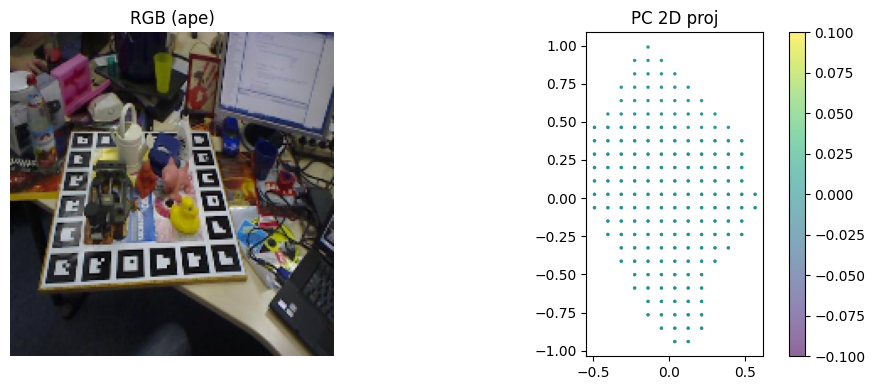

In [9]:
# (Optional) Cell 6c — Quick sanity check/visualization
print("Creating datasets...")
train_dataset = LinemodDataset(CFG["data_root"], split='train', img_size=CFG["img_size"], num_points=CFG["pc_n"])
test_dataset  = LinemodDataset(CFG["data_root"], split='test',  img_size=CFG["img_size"], num_points=CFG["pc_n"])
print(f"Training samples: {len(train_dataset)} | Test samples: {len(test_dataset)}")

if len(train_dataset) > 0:
    s = train_dataset[0]
    print({k: (tuple(v.shape) if torch.is_tensor(v) else v) for k,v in s.items() if k in ["rgb","pc","R_gt","t_gt","object","is_symmetric"]})
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    axes[0].imshow(s["rgb"].permute(1,2,0).numpy()); axes[0].set_title(f"RGB ({s['object']})"); axes[0].axis('off')
    pc = s["pc"].numpy()
    sc = axes[1].scatter(pc[:,0], pc[:,1], s=2, c=pc[:,2], alpha=0.6)
    axes[1].set_title("PC 2D proj"); axes[1].set_aspect('equal'); plt.colorbar(sc, ax=axes[1])
    plt.tight_layout(); plt.show()


In [10]:
class DWSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=7, s=4, p=3):
        super().__init__()
        self.dw = nn.Conv2d(in_ch, in_ch, k, s, p, groups=in_ch, bias=False)
        self.pw = nn.Conv2d(in_ch, out_ch, 1, 1, 0, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.SiLU()
    def forward(self, x):
        x = self.dw(x); x = self.pw(x); x = self.bn(x); x = self.act(x)
        return x

class GroupedPatchEmbedding(nn.Module):
    def __init__(self, in_ch, emb_ch, patch_stride=4):
        super().__init__()
        # depthwise separable conv with stride -> token grid (H/ps, W/ps)
        self.conv = DWSeparableConv(in_ch, emb_ch, k=7, s=patch_stride, p=3)
        self.ln = nn.LayerNorm(emb_ch)
    def forward(self, x):
        x = self.conv(x)                                  # (B, emb_ch, H/ps, W/ps)
        x = rearrange(x, "b c h w -> b (h w) c")         # (B, N, emb_ch)
        x = self.ln(x)
        return x



class MBFFN(nn.Module):
    # Dual-branch DWConvs 3x3 & 5x5 -> concat -> MLP with residual
    def __init__(self, dim, hidden_mult=4):
        super().__init__()
        hid = dim * hidden_mult
        self.dw3 = nn.Conv2d(dim, dim, 3, 1, 1, groups=dim)
        self.dw5 = nn.Conv2d(dim, dim, 5, 1, 2, groups=dim)
        self.proj = nn.Sequential(
            nn.Linear(dim*2, hid), nn.GELU(), nn.Linear(hid, dim)
        )
    def forward(self, x_seq):
        # x_seq: (B,N,C) -> spatialize with square guess
        B,N,C = x_seq.shape
        H = W = int(math.sqrt(N))
        x = rearrange(x_seq, "b (h w) c -> b c h w", h=H, w=W)
        a = self.dw3(x)
        b = self.dw5(x)
        y = torch.cat([a,b], dim=1)                 # (B,2C,H,W)
        y = rearrange(y, "b c h w -> b (h w) c")
        y = self.proj(y)
        return x_seq + y


In [11]:
class MRSA(nn.Module):
    """
    Multi-resolution self-attention:
    - downsample K,V by stride-n depthwise conv (n in {8,4,2,1} across stages)
    - local detail receptor via DWConv5x5 on K,V additions
    - DropKey: randomly zero a subset of key positions before attention softmax
    """
    def __init__(self, dim, heads=4, sr=4, dropkey_p=0.1):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim, dim, bias=False)
        self.to_v = nn.Linear(dim, dim, bias=False)
        self.proj = nn.Linear(dim, dim)
        self.sr = sr
        # SR conv applied in image space; we need a reshape hook
        self.dw_k = nn.Conv2d(dim, dim, 5, 1, 2, groups=dim)  # local receptor
        self.dw_v = nn.Conv2d(dim, dim, 5, 1, 2, groups=dim)
        self.dropkey_p = dropkey_p

    def forward(self, x_seq, H, W):
        B,N,C = x_seq.shape
        q = self.to_q(x_seq)
        q = rearrange(q, "b n (h d) -> b h n d", h=self.heads)

        # prepare K,V via SR
        x_img = rearrange(x_seq, "b (h w) c -> b c h w", h=H, w=W)
        if self.sr > 1:
            k_in = F.avg_pool2d(x_img, kernel_size=self.sr, stride=self.sr)
            v_in = k_in
        else:
            k_in = x_img; v_in = x_img

        k_in = self.dw_k(k_in)
        v_in = self.dw_v(v_in)

        k_seq = rearrange(k_in, "b c h w -> b (h w) c")
        v_seq = rearrange(v_in, "b c h w -> b (h w) c")

        k = self.to_k(k_seq); v = self.to_v(v_seq)
        k = rearrange(k, "b n (h d) -> b h n d", h=self.heads)
        v = rearrange(v, "b n (h d) -> b h n d", h=self.heads)

        attn = torch.einsum("b h i d, b h j d -> b h i j", q, k) * self.scale

        # DropKey: randomly mask some keys (per batch) before softmax
        if self.training and self.dropkey_p > 0:
            mask = (torch.rand(attn.shape[:3] + (attn.shape[3],), device=attn.device) > self.dropkey_p)
            attn = attn.masked_fill(~mask, float('-inf'))

        attn = attn.softmax(dim=-1)
        out = torch.einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.proj(out)
        return out

class CFormerBlock(nn.Module):
    def __init__(self, dim, heads, sr, dropkey_p=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MRSA(dim, heads=heads, sr=sr, dropkey_p=dropkey_p)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = MBFFN(dim)

    def forward(self, x, H, W):
        x = x + self.attn(self.norm1(x), H, W)
        x = x + self.ffn(self.norm2(x))
        return x


In [12]:
class CFormer(nn.Module):
    def __init__(self, in_ch=3, base_dim=96, heads=4, scales=(8,4,2,1), dropkey_p=0.1, patch_stride=4):
        super().__init__()
        self.base_dim = base_dim
        self.gpe = GroupedPatchEmbedding(in_ch, base_dim, patch_stride=patch_stride)

        # NEW: channel aligner (handles accidental 2x channels from upstream)
        self.in_align = nn.Linear(base_dim, base_dim, bias=False)

        self.blocks = nn.ModuleList([
            CFormerBlock(base_dim, heads, sr=sc, dropkey_p=dropkey_p) for sc in scales
        ])

    def forward(self, x):
        B, _, H0, W0 = x.shape
        seq = self.gpe(x)                                 # (B, N, Cgpe)
        # debug print once
        if not hasattr(self, "_printed_shape"):
          print(f"[CFormer] gpe seq shape: {tuple(seq.shape)} (expect last dim≈{self.base_dim})")
          self._printed_shape = True

        # Force-align last dim to base_dim (covers cases where Cgpe != base_dim)
        if seq.size(-1) != self.base_dim:
            # create a runtime align layer to project Cgpe -> base_dim
            # (works even if Cgpe == 2*base_dim)
            align = nn.Linear(seq.size(-1), self.base_dim, bias=False).to(seq.device)
            with torch.no_grad():
                # Kaiming-normal for stable start
                nn.init.kaiming_uniform_(align.weight, a=math.sqrt(5))
            seq = align(seq)
        else:
            seq = self.in_align(seq)

        H = H0 // 4; W = W0 // 4                         # patch_stride=4
        feats = []
        cur = seq
        for i, blk in enumerate(self.blocks):
            cur = blk(cur, H, W)
            fmap = rearrange(cur, "b (h w) c -> b c h w", h=H, w=W)
            feats.append(fmap)
            if i < len(self.blocks) - 1:
                fmap = F.avg_pool2d(fmap, 2, 2)          # pyramid downsample
                H, W = H // 2, W // 2
                cur = rearrange(fmap, "b c h w -> b (h w) c")
        return feats


In [13]:
class RelPosBias(nn.Module):
    def __init__(self, in_dim=3, hidden=64, out_dim=1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.GELU(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, pij):
        # pij: (..., 3) normalized diff
        # normalize and feed MLP
        nrm = pij / (torch.norm(pij, dim=-1, keepdim=True) + 1e-6)
        return self.mlp(nrm).squeeze(-1)

class PointAttn(nn.Module):
    def __init__(self, dim=128, heads=4):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim, dim, bias=False)
        self.to_v = nn.Linear(dim, dim, bias=False)
        self.rel = RelPosBias(3, hidden=64, out_dim=1)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x, xyz):
        # x: (B,N,C), xyz: (B,N,3)
        B,N,C = x.shape
        q = rearrange(self.to_q(x), "b n (h d) -> b h n d", h=self.heads)
        k = rearrange(self.to_k(x), "b n (h d) -> b h n d", h=self.heads)
        v = rearrange(self.to_v(x), "b n (h d) -> b h n d", h=self.heads)

        # compute pairwise bias r_ij on the fly (vectorized)
        # xyz_diff: (B,N,N,3)
        xi = xyz[:, :, None, :]
        xj = xyz[:, None, :, :]
        pij = xi - xj
        bias = self.rel(pij)  # (B,N,N)

        attn = torch.einsum("b h i d, b h j d -> b h i j", q, k) * self.scale
        attn = attn + bias[:, None, :, :]  # broadcast over heads
        attn = attn.softmax(dim=-1)

        out = torch.einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.proj(out)
        return out

class GFormerBlock(nn.Module):
    def __init__(self, dim=128, heads=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = PointAttn(dim, heads)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim*4), nn.GELU(), nn.Linear(dim*4, dim)
        )
    def forward(self, x, xyz):
        x = x + self.attn(self.norm1(x), xyz)
        x = x + self.ffn(self.norm2(x))
        return x

class GFormer(nn.Module):
    def __init__(self, in_dim=3, dim=128, heads=4, depth=4):
        super().__init__()
        self.embed = nn.Linear(in_dim, dim)
        self.blocks = nn.ModuleList([GFormerBlock(dim, heads) for _ in range(depth)])
        self.out_proj = nn.Linear(dim, dim)
    def forward(self, xyz):
        # xyz: (B,N,3)
        x = self.embed(xyz)
        for blk in self.blocks:
            x = blk(x, xyz)
        # global avg pooling preferred for pose (per paper discussion)
        g = x.mean(dim=1, keepdim=True)
        x = self.out_proj(g)  # (B,1,C)
        return x.squeeze(1)   # (B,C)


In [14]:
class CrossModalSelfAttention(nn.Module):
    def __init__(self, dim, heads=4, temp=1.0):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.temp = temp
        self.q = nn.Linear(dim, dim, bias=False)
        self.k = nn.Linear(dim, dim, bias=False)
        self.v = nn.Linear(dim, dim, bias=False)
        self.proj = nn.Linear(dim, dim)
        self.ln = nn.LayerNorm(dim)

    def forward(self, f_raw):
        # f_raw: (B,N,C)
        x = self.ln(f_raw)
        q = rearrange(self.q(x), "b n (h d) -> b h n d", h=self.heads)
        k = rearrange(self.k(x), "b n (h d) -> b h n d", h=self.heads)
        v = rearrange(self.v(x), "b n (h d) -> b h n d", h=self.heads)
        attn = torch.einsum("b h i d, b h j d -> b h i j", q, k) * self.scale
        attn = (attn / self.temp).softmax(dim=-1)
        out = torch.einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.proj(out)
        out = out + f_raw
        out = self.ln(out)
        return out

class MSTF(nn.Module):
    def __init__(self, dim=96, heads=4):
        super().__init__()
        self.reduce = nn.Conv2d(dim * 2, dim, 1, 1, 0)
        self.attn = CrossModalSelfAttention(dim, heads)
        self.fuse = nn.Sequential(
            nn.Conv2d(dim * 2, dim, 1, 1, 0),
            nn.BatchNorm2d(dim),
            nn.SiLU()
        )

    def forward(self, feats_rgb, feat_pc):
        fused_maps = []
        for fmap in feats_rgb:
            B, C, H, W = fmap.shape
            pc_map = feat_pc[:, :, None, None].expand(B, C, H, W)   # (B,C,H,W)
            raw2C = torch.cat([fmap, pc_map], dim=1)                # (B,2C,H,W)

            red = self.reduce(raw2C)                                # (B,C,H,W)
            seq = rearrange(red, "b c h w -> b (h w) c")            # (B,HW,C)
            seq = self.attn(seq)                                    # (B,HW,C)
            key = rearrange(seq, "b (h w) c -> b c h w", h=H, w=W)  # (B,C,H,W)

            # (Optional) one-time debug print (now AFTER vars exist)
            if not hasattr(self, "_dbg"):
                print(f"[MSTF] raw2C {tuple(raw2C.shape)} -> red {tuple(red.shape)} -> seq {tuple(seq.shape)}")
                self._dbg = True

            g = F.adaptive_max_pool2d(key, 1)                       # (B,C,1,1)
            dense = torch.cat([key, g.expand_as(key)], dim=1)       # (B,2C,H,W)
            fused = self.fuse(dense)                                # (B,C,H,W)
            fused_maps.append(fused)
        return fused_maps



class RegressionHead(nn.Module):
    def __init__(self, in_ch=96, out_dim=9):
        super().__init__()
        # after upsampling, channels = in_ch * (#scales)
        self.head = nn.Sequential(
            nn.Conv2d(in_ch * len(CFG["rgb_scales"]), in_ch, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, in_ch, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(in_ch, out_dim)

    def forward(self, fused_maps):
        # align spatial sizes to the first (largest) map
        refH, refW = fused_maps[0].shape[-2], fused_maps[0].shape[-1]
        aligned = [fused_maps[0]]
        for fm in fused_maps[1:]:
            if fm.shape[-2:] != (refH, refW):
                fm = F.interpolate(fm, size=(refH, refW), mode='bilinear', align_corners=False)
            aligned.append(fm)
        x = torch.cat(aligned, dim=1)            # (B, in_ch*#scales, refH, refW)
        x = self.head(x)                         # -> (B, in_ch, 1, 1)
        x = x.flatten(1)
        out = self.fc(x)                         # (B, 9) -> 6D rot + t
        rot6d, t = out[:, :6], out[:, 6:9]
        return rot6d, t


In [15]:
class FormerPose(nn.Module):
    def __init__(self, img_ch=3, dim=128, heads=4, scales=(8,4,2,1), dropkey=0.1):
        super().__init__()
        self.cformer = CFormer(img_ch, dim, heads, scales, dropkey)
        self.gformer = GFormer(3, dim, heads, depth=4)
        self.mstf = MSTF(dim, heads)
        self.head = RegressionHead(in_ch=dim, out_dim=9)

    def forward(self, rgb, pc):
        # rgb: (B,3,H,W), pc: (B,N,3)
        feats_rgb = self.cformer(rgb)     # list of (B,C,H,W)
        feat_pc = self.gformer(pc)        # (B,C)
        fused = self.mstf(feats_rgb, feat_pc)
        rot6d, t = self.head(fused)
        return rot6d, t


In [16]:
class PoseLoss(nn.Module):
    def __init__(self, w_rot=1.0, w_trans=1.0, w_add=1.0, use_add=False, model_bank=None, sym_ids=set()):
        super().__init__()
        self.wr = w_rot; self.wt = w_trans; self.wa = w_add
        self.use_add = use_add
        self.model_bank = model_bank or {}
        self.sym_ids = sym_ids

    def forward(self, rot6d, t, R_gt, t_gt, obj_ids):
        # convert rot6d -> R
        R_pred = rot6d_to_mat(rot6d)          # (B,3,3)
        # rot loss: geodesic (via trace)
        I = torch.eye(3, device=R_pred.device).unsqueeze(0).expand_as(R_pred)
        rel = torch.matmul(R_pred.transpose(1,2), R_gt)  # R_p^T R_gt
        tr = rel[:,0,0] + rel[:,1,1] + rel[:,2,2]
        geodesic = torch.acos(torch.clamp((tr - 1)/2, -1+1e-6, 1-1e-6))
        loss_rot = geodesic.mean()

        loss_t = F.l1_loss(t, t_gt)

        loss = self.wr * loss_rot + self.wt * loss_t

        if self.use_add and len(self.model_bank) > 0:
            add_terms = []
            R_pred_np = R_pred.detach().cpu().numpy()
            t_pred_np = t.detach().cpu().numpy()
            R_gt_np   = R_gt.detach().cpu().numpy()
            t_gt_np   = t_gt.detach().cpu().numpy()
            for i in range(obj_ids.shape[0]):
                oid = int(obj_ids[i])
                if oid not in self.model_bank: continue
                mp = self.model_bank[oid]
                sym = (oid in self.sym_ids)
                err = add_s_error(mp, R_pred_np[i], t_pred_np[i], R_gt_np[i], t_gt_np[i]) if sym \
                    else add_error(mp, R_pred_np[i], t_pred_np[i], R_gt_np[i], t_gt_np[i])
                add_terms.append(err)
            if add_terms:
                loss = loss + self.wa * (torch.tensor(add_terms, device=rot6d.device).mean())
        return loss


In [17]:
def load_model_points_bank(root):
    bank = {}
    for npy in glob.glob(os.path.join(root, "*.npy")):
        # Filename convention: obj_{id}.npy or {id}.npy
        name = Path(npy).stem
        try:
            oid = int(name.split("_")[-1])
        except:
            try:
                oid = int(name)
            except:
                continue
        bank[oid] = np.load(npy).astype(np.float32)
    return bank

MODEL_BANK = load_model_points_bank(CFG["model_points"])


In [18]:
class AverageMeter:
    def __init__(self):
        self.reset()
    def reset(self):
        self.sum = 0; self.cnt = 0
    def update(self, val, n=1):
        self.sum += val * n; self.cnt += n
    @property
    def avg(self):
        return self.sum / max(1,self.cnt)

def make_model():
    net = FormerPose(img_ch=3, dim=CFG["hidden"], heads=4, scales=CFG["rgb_scales"], dropkey=CFG["dropkey_p"]).to(DEVICE)
    return net

def train_one_epoch(net, loader, opt, loss_fn):
    net.train()
    meter = AverageMeter()
    for batch in tqdm(loader, desc="train", leave=False):
        rgb = batch["rgb"].to(DEVICE)
        pc = batch["pc"].to(DEVICE)
        R_gt = batch["R_gt"].to(DEVICE)
        t_gt = batch["t_gt"].to(DEVICE)
        obj = batch["obj_id"].to(DEVICE)

        opt.zero_grad()
        rot6d, t = net(rgb, pc)
        loss = loss_fn(rot6d, t, R_gt, t_gt, obj)
        loss.backward()
        opt.step()
        meter.update(loss.item(), rgb.size(0))
    return meter.avg

@torch.no_grad()
def validate(net, loader, model_bank, sym_ids):
    net.eval()
    all_errs = []
    for batch in tqdm(loader, desc="val", leave=False):
        rgb = batch["rgb"].to(DEVICE)
        pc = batch["pc"].to(DEVICE)
        R_gt = batch["R_gt"].cpu().numpy()
        t_gt = batch["t_gt"].cpu().numpy()
        obj = batch["obj_id"].cpu().numpy()

        rot6d, t = net(rgb, pc)
        R_pred = rot6d_to_mat(rot6d).cpu().numpy()
        t_pred = t.cpu().numpy()

        # Example: report ADD(S) @ 0.1d success per instance
        for i in range(rgb.size(0)):
            oid = int(obj[i])
            if oid not in model_bank: continue
            mp = model_bank[oid]
            sym = oid in sym_ids
            err = add_s_error(mp, R_pred[i], t_pred[i], R_gt[i], t_gt[i]) if sym \
                else add_error(mp, R_pred[i], t_pred[i], R_gt[i], t_gt[i])
            all_errs.append(err)
    if not all_errs:
        return {"mean_ADD(S)": None}
    return {"mean_ADD(S)": float(np.mean(all_errs))}


In [19]:
# === Quick sanity config (keep it together) ===
from torch.utils.data import Subset, DataLoader
import numpy as np
import math, torch

def enable_quick_sanity(
    max_train_batches=10, max_val_batches=10,
    train_subset_size=200, val_subset_size=200,
    fast_bank_pts=500
):
    # 1) Lighter model & inputs
    CFG.update({
        "epochs": 1,
        "batch_size": 2,
        "num_workers": 2,
        "img_size": 128,     # smaller images
        "pc_n": 256,         # fewer points
        "hidden": 64,        # smaller channels
    })

    # 2) Rebuild loaders on small subsets
    full_tr = LinemodDataset(CFG["data_root"], split="train",
                             img_size=CFG["img_size"], num_points=CFG["pc_n"])
    full_va = LinemodDataset(CFG["data_root"], split="test",
                             img_size=CFG["img_size"], num_points=CFG["pc_n"])

    tr_idx = np.arange(min(len(full_tr), train_subset_size))
    va_idx = np.arange(min(len(full_va), val_subset_size))
    ds_tr = Subset(full_tr, tr_idx.tolist())
    ds_va = Subset(full_va, va_idx.tolist())

    tr_loader = DataLoader(
        ds_tr, batch_size=CFG["batch_size"], shuffle=True,
        num_workers=CFG["num_workers"], drop_last=True, pin_memory=True
    )
    va_loader = DataLoader(
        ds_va, batch_size=CFG["batch_size"], shuffle=False,
        num_workers=CFG["num_workers"], drop_last=False, pin_memory=True
    )

    # 3) Make a small (fast) model bank (XYZ only)
    base_ds = full_tr  # has .objects/.obj2id/.model_points
    MODEL_BANK_SMALL = {}
    rng = np.random.default_rng(0)
    for name in base_ds.objects:
        oid = base_ds.obj2id[name]
        pts = base_ds.model_points[name]
        if pts.ndim == 1: pts = pts.reshape(-1, 3)
        if pts.shape[1] > 3: pts = pts[:, :3]
        if pts.shape[0] > fast_bank_pts:
            pick = rng.choice(pts.shape[0], size=fast_bank_pts, replace=False)
            pts = pts[pick]
        MODEL_BANK_SMALL[oid] = pts.astype(np.float32)

    SYM_IDS_SMALL = set([base_ds.obj2id[n] for n in base_ds.symmetric_set if n in base_ds.obj2id])

    print(f"[quick] train_subset={len(ds_tr)}  val_subset={len(ds_va)}  bank_pts≤{fast_bank_pts}")
    return tr_loader, va_loader, MODEL_BANK_SMALL, SYM_IDS_SMALL, max_train_batches, max_val_batches


In [20]:
# === Slimmed train/val loops with step caps ===
from torch.amp import autocast, GradScaler

def train_one_epoch_small(net, loader, opt, loss_fn, max_steps=10):
    net.train()
    scaler = GradScaler("cuda", enabled=(DEVICE=='cuda'))
    meter_loss = 0.0; seen = 0
    opt.zero_grad(set_to_none=True)
    for step, batch in enumerate(tqdm(loader, desc="train(small)", leave=False)):
        if step >= max_steps: break
        rgb = batch["rgb"].to(DEVICE)
        pc  = batch["pc"].to(DEVICE)
        Rgt = batch["R_gt"].to(DEVICE)
        tgt = batch["t_gt"].to(DEVICE)
        obj = batch["obj_id"].to(DEVICE)

        with autocast("cuda", enabled=(DEVICE=='cuda')):
            rot6d, t = net(rgb, pc)
            loss = loss_fn(rot6d, t, Rgt, tgt, obj)

        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        opt.zero_grad(set_to_none=True)

        bs = rgb.size(0)
        meter_loss += loss.item() * bs
        seen += bs
    return meter_loss / max(1, seen)

@torch.no_grad()
def validate_small(net, loader, model_bank, sym_ids, max_batches=10):
    net.eval()
    all_errs = []
    for bi, batch in enumerate(tqdm(loader, desc="val(small)", leave=False)):
        if bi >= max_batches: break
        rgb = batch["rgb"].to(DEVICE)
        pc  = batch["pc"].to(DEVICE)
        Rgt = batch["R_gt"].to(DEVICE)
        tgt = batch["t_gt"].to(DEVICE)
        obj = batch["obj_id"].cpu().numpy()

        rot6d, t = net(rgb, pc)
        Rpr = rot6d_to_mat(rot6d)   # (B,3,3)
        tpr = t

        for i in range(rgb.size(0)):
            oid = int(obj[i])
            if oid not in model_bank: continue
            mp = torch.from_numpy(model_bank[oid]).to(DEVICE)  # (M,3)

            Pp = (mp @ Rpr[i].T) + tpr[i]
            Pg = (mp @ Rgt[i].T) + tgt[i]
            if oid in sym_ids:
                d = torch.cdist(Pp[None], Pg[None]).squeeze(0)
                err = d.min(dim=1).values.mean().item()
            else:
                err = (Pp - Pg).norm(dim=1).mean().item()
            all_errs.append(err)

    return {"mean_ADD(S)": float(np.mean(all_errs)) if all_errs else None}

# === Run a tiny end-to-end check ===
tr_small, va_small, BANK_SMALL, SYM_SMALL, MAX_TR, MAX_VA = enable_quick_sanity(
    max_train_batches=10, max_val_batches=10,
    train_subset_size=200, val_subset_size=200,
    fast_bank_pts=500
)

net = FormerPose(img_ch=3, dim=CFG["hidden"], heads=2,  # heads=2 for speed
                 scales=CFG["rgb_scales"], dropkey=CFG["dropkey_p"]).to(DEVICE)

opt = torch.optim.AdamW(net.parameters(), lr=2e-4, weight_decay=1e-4)
crit = PoseLoss(w_rot=1.0, w_trans=1.0, w_add=0.25, use_add=True,
                model_bank=BANK_SMALL, sym_ids=SYM_SMALL)

tl = train_one_epoch_small(net, tr_small, opt, crit, max_steps=MAX_TR)
metrics = validate_small(net, va_small, BANK_SMALL, SYM_SMALL, max_batches=MAX_VA)
print(f"[quick sanity] train_loss={tl:.4f}  val_mean_ADD(S)={metrics['mean_ADD(S)']}")



Loading TRAIN split from: /content/LINEMOD/LINEMOD
Objects: ape, benchvise, cam, can, cat, driller, duck, eggbox, glue, holepuncher, iron, lamp, phone

Loading model points:
  ✓ ape            : 99986 points (dense_pts.txt)
  ✓ benchvise      : 99847 points (dense_pts.txt)
  ✓ cam            : 100093 points (dense_pts.txt)
  ✓ can            : 99898 points (dense_pts.txt)
  ✓ cat            : 99921 points (dense_pts.txt)
  ✓ driller        : 100049 points (dense_pts.txt)
  ✓ duck           : 100058 points (dense_pts.txt)
  ✓ eggbox         : 99903 points (dense_pts.txt)
  ✓ glue           : 99941 points (dense_pts.txt)
  ✓ holepuncher    : 100372 points (dense_pts.txt)
  ✓ iron           : 99885 points (dense_pts.txt)
  ✓ lamp           : 100041 points (dense_pts.txt)
  ✓ phone          : 100041 points (dense_pts.txt)
  ape            :  186 samples
  benchvise      :  183 samples
  cam            :  181 samples
  can            :  180 samples
  cat            :  177 samples
  driller

train(small):   0%|          | 0/100 [00:00<?, ?it/s]

[CFormer] gpe seq shape: (2, 1024, 64) (expect last dim≈64)
[MSTF] raw2C (2, 128, 32, 32) -> red (2, 64, 32, 32) -> seq (2, 1024, 64)


[quick sanity] train_loss=2.6529  val_mean_ADD(S)=0.9917881160974502


In [22]:
# ===== Per-epoch detailed metrics: train (loss, rot°, |t|) + val (ADD(S) mean, SR@0.1d) =====
import numpy as np
from torch.utils.data import Subset, DataLoader
from torch.amp import autocast, GradScaler
import torch

# --- helpers ---
def compute_obj_diameters(model_bank: dict):
    # quick diameter approximation from axis-aligned bbox (fast & ok for SR thresholding)
    diam = {}
    for oid, pts in model_bank.items():
        p = pts[:, :3] if pts.shape[1] > 3 else pts
        rng = p.max(0) - p.min(0)
        diam[oid] = float(np.linalg.norm(rng))
    return diam

@torch.no_grad()
def rot_geodesic_deg(R_pred, R_gt):
    R_pred = R_pred.float()
    R_gt   = R_gt.float()
    rel = torch.matmul(R_pred.transpose(1,2), R_gt)
    tr = rel[:,0,0] + rel[:,1,1] + rel[:,2,2]
    ang = torch.acos(torch.clamp((tr - 1)/2, -1+1e-6, 1-1e-6))
    return ang * (180.0 / np.pi)

net = FormerPose(img_ch=3, dim=CFG["hidden"], heads=2,  # heads=2 for speed
                 scales=CFG["rgb_scales"], dropkey=CFG["dropkey_p"]).to(DEVICE)

opt = torch.optim.AdamW(net.parameters(), lr=2e-4, weight_decay=1e-4)
crit = PoseLoss(w_rot=1.0, w_trans=1.0, w_add=0.25, use_add=True,
                model_bank=BANK_SMALL, sym_ids=SYM_SMALL)
# === Rebuild MODEL_BANK and SYM_IDS from your train dataset ===
tr, va, _, _ = get_loaders()  # reuse your loader to get obj maps/points
ds_tr = tr.dataset  # extract Dataset from your DataLoader

MODEL_BANK = {}
for name in ds_tr.objects:
    oid = ds_tr.obj2id[name]
    pts = ds_tr.model_points[name]
    if pts.ndim == 1:
        pts = pts.reshape(-1, 3)
    if pts.shape[1] > 3:  # keep only XYZ
        pts = pts[:, :3]
    MODEL_BANK[oid] = pts.astype(np.float32)

# Identify symmetric objects (LINEMOD usually has 'eggbox' and 'glue')
SYM_IDS = set(
    [ds_tr.obj2id[n] for n in getattr(ds_tr, "symmetric_set", ["eggbox", "glue"]) if n in ds_tr.obj2id]
)

# Optional: small bank for fast validation
def make_fast_bank(model_bank, max_pts=2000, seed=0):
    import numpy as np
    fast = {}
    rng = np.random.default_rng(seed)
    for oid, pts in model_bank.items():
        if pts.ndim == 1:
            pts = pts.reshape(-1, 3)
        if pts.shape[1] > 3:
            pts = pts[:, :3]
        if pts.shape[0] > max_pts:
            idx = rng.choice(pts.shape[0], size=max_pts, replace=False)
            fast[oid] = pts[idx].astype(np.float32)
        else:
            fast[oid] = pts.astype(np.float32)
    return fast

MODEL_BANK_FAST = make_fast_bank(MODEL_BANK, max_pts=2000)

print(f"✅ MODEL_BANK built for {len(MODEL_BANK)} objects.")
print(f"✅ SYM_IDS = {SYM_IDS}")

# Downsampled bank for fast validation
MODEL_BANK_FAST = make_fast_bank(MODEL_BANK, max_pts=2000)
OBJ_DIAM_FAST   = compute_obj_diameters(MODEL_BANK_FAST)
# Small validation subset loader for speed (change size as you like)
VAL_SUBSET = 100
rng_np = np.random.RandomState(0)
base_va = va.dataset
va_idx = rng_np.choice(len(base_va), size=min(VAL_SUBSET, len(base_va)), replace=False)
va_small = DataLoader(
    Subset(base_va, va_idx.tolist()),
    batch_size=CFG["batch_size"],
    shuffle=False, num_workers=CFG["num_workers"], drop_last=False, pin_memory=True
)

print(f"[setup] train_samples={len(tr.dataset)} | val_full={len(va.dataset)} | val_small={len(va_small.dataset)}")

# --- train with per-batch metric accumulation ---
def train_one_epoch_metrics(net, loader, opt, loss_fn, accum_steps=2):
    net.train()
    scaler = GradScaler("cuda", enabled=(DEVICE=='cuda'))
    meter_loss, meter_rot_deg, meter_t_l1, seen = 0.0, 0.0, 0.0, 0
    opt.zero_grad(set_to_none=True)

    for it, batch in enumerate(tqdm(loader, desc="train", leave=False)):
        rgb = batch["rgb"].to(DEVICE)
        pc  = batch["pc"].to(DEVICE)
        Rgt = batch["R_gt"].to(DEVICE)
        tgt = batch["t_gt"].to(DEVICE)
        obj = batch["obj_id"].to(DEVICE)

        with autocast("cuda", enabled=(DEVICE=='cuda')):
            rot6d, t = net(rgb, pc)
            loss = loss_fn(rot6d, t, Rgt, tgt, obj) / accum_steps

        scaler.scale(loss).backward()

        if (it + 1) % accum_steps == 0:
            scaler.step(opt); scaler.update()
            opt.zero_grad(set_to_none=True)

        # accumulate metrics (no graph needed)
        with torch.no_grad():
            bs = rgb.size(0)
            Rpr = rot6d_to_mat(rot6d).float()
            rot_deg = rot_geodesic_deg(Rpr, Rgt.float())
            t_l1 = torch.abs(t.float() - tgt.float()).mean(dim=1)

            meter_loss   += (loss.item() * accum_steps) * bs
            meter_rot_deg+= rot_deg.mean().item() * bs
            meter_t_l1   += t_l1.mean().item() * bs
            seen += bs

    return {
        "loss": meter_loss / max(1, seen),
        "rot_deg": meter_rot_deg / max(1, seen),
        "t_l1": meter_t_l1 / max(1, seen),
    }

# --- validation: mean ADD(S) & success rate @ 0.1d ---
@torch.no_grad()
def validate_metrics(net, loader, model_bank, sym_ids, obj_diam, max_batches=None, thresh_ratio=0.1):
    net.eval()
    add_list = []
    total, correct = 0, 0

    for bi, batch in enumerate(tqdm(loader, desc="val", leave=False)):
        if max_batches is not None and bi >= max_batches: break

        rgb = batch["rgb"].to(DEVICE)
        pc  = batch["pc"].to(DEVICE)
        Rgt = batch["R_gt"].to(DEVICE)
        tgt = batch["t_gt"].to(DEVICE)
        obj = batch["obj_id"].cpu().numpy()

        rot6d, t = net(rgb, pc)
        Rpr = rot6d_to_mat(rot6d).float()  # ensure FP32 for geometry
        tpr = t.float()

        for i in range(rgb.size(0)):
            oid = int(obj[i])
            if oid not in model_bank: continue
            mp = torch.from_numpy(model_bank[oid]).to(DEVICE)  # (M,3)
            # project
            Pp = (mp @ Rpr[i].T) + tpr[i]
            Pg = (mp @ Rgt[i].T) + tgt[i]
            if oid in sym_ids:
                d = torch.cdist(Pp[None], Pg[None]).squeeze(0)   # (M,M)
                err = d.min(dim=1).values.mean().item()
            else:
                err = (Pp - Pg).norm(dim=1).mean().item()
            add_list.append(err)
            thr = obj_diam.get(oid, 0.2) * thresh_ratio
            correct += (err < thr)
            total += 1

    mean_adds = float(np.mean(add_list)) if add_list else None
    sr = (correct / max(1, total)) * 100.0
    return {"mean_ADD(S)": mean_adds, "SR@0.1d(%)": sr}

# --- run 10 epochs: small val each epoch, full every 5th (with full bank) ---
CFG["epochs"] = 50
accum_steps = 1

for ep in range(1, CFG["epochs"] + 1):
    trm = train_one_epoch_metrics(net, tr, opt, crit, accum_steps=accum_steps)
    # sched.step()

    use_full = (ep % 51 == 0)
    vloader  = va if use_full else va_small
    vbank    = MODEL_BANK if use_full else MODEL_BANK_FAST
    vdiam    = compute_obj_diameters(vbank) if use_full else OBJ_DIAM_FAST
    tag      = "FULL" if use_full else "SMALL"

    vm = validate_metrics(net, vloader, vbank, SYM_IDS, vdiam)

    print(f"[{ep:03d}/{CFG["epochs"]}] "
          f"train_loss={trm['loss']:.4f} | train_rot_deg={trm['rot_deg']:.2f} | train_tL1={trm['t_l1']:.4f}  ||  "
          f"val({tag})_mean_ADD(S)={vm['mean_ADD(S)']:.6f} | val({tag})_SR@0.1d={vm['SR@0.1d(%)']:.2f}%")

    torch.save(net.state_dict(), os.path.join(CFG["save_dir"], f"formerpose_ep{ep}.pth"))





Loading TRAIN split from: /content/LINEMOD/LINEMOD
Objects: ape, benchvise, cam, can, cat, driller, duck, eggbox, glue, holepuncher, iron, lamp, phone

Loading model points:
  ✓ ape            : 99986 points (dense_pts.txt)
  ✓ benchvise      : 99847 points (dense_pts.txt)
  ✓ cam            : 100093 points (dense_pts.txt)
  ✓ can            : 99898 points (dense_pts.txt)
  ✓ cat            : 99921 points (dense_pts.txt)
  ✓ driller        : 100049 points (dense_pts.txt)
  ✓ duck           : 100058 points (dense_pts.txt)
  ✓ eggbox         : 99903 points (dense_pts.txt)
  ✓ glue           : 99941 points (dense_pts.txt)
  ✓ holepuncher    : 100372 points (dense_pts.txt)
  ✓ iron           : 99885 points (dense_pts.txt)
  ✓ lamp           : 100041 points (dense_pts.txt)
  ✓ phone          : 100041 points (dense_pts.txt)
  ape            :  186 samples
  benchvise      :  183 samples
  cam            :  181 samples
  can            :  180 samples
  cat            :  177 samples
  driller

train:   0%|          | 1/1187 [00:00<03:56,  5.02it/s]

[CFormer] gpe seq shape: (2, 1024, 64) (expect last dim≈64)
[MSTF] raw2C (2, 128, 32, 32) -> red (2, 64, 32, 32) -> seq (2, 1024, 64)


[001/50] train_loss=1.7494 | train_rot_deg=93.03 | train_tL1=0.0819  ||  val(SMALL)_mean_ADD(S)=0.287815 | val(SMALL)_SR@0.1d=0.00%


[002/50] train_loss=1.6994 | train_rot_deg=91.57 | train_tL1=0.0659  ||  val(SMALL)_mean_ADD(S)=0.154055 | val(SMALL)_SR@0.1d=1.00%


[003/50] train_loss=1.6806 | train_rot_deg=90.53 | train_tL1=0.0653  ||  val(SMALL)_mean_ADD(S)=0.225038 | val(SMALL)_SR@0.1d=0.00%


[004/50] train_loss=1.6547 | train_rot_deg=89.34 | train_tL1=0.0618  ||  val(SMALL)_mean_ADD(S)=0.294453 | val(SMALL)_SR@0.1d=1.00%


[005/50] train_loss=1.6312 | train_rot_deg=88.08 | train_tL1=0.0609  ||  val(SMALL)_mean_ADD(S)=0.152118 | val(SMALL)_SR@0.1d=2.00%


[006/50] train_loss=1.5996 | train_rot_deg=86.43 | train_tL1=0.0591  ||  val(SMALL)_mean_ADD(S)=0.164301 | val(SMALL)_SR@0.1d=0.00%


[007/50] train_loss=1.5561 | train_rot_deg=84.26 | train_tL1=0.0552  ||  val(SMALL)_mean_ADD(S)=0.155547 | val(SMALL)_SR@0.1d=0.00%


[008/50] train_loss=1.4858 | train_rot_deg=80.33 | train_tL1=0.0541  ||  val(SMALL)_mean_ADD(S)=0.284850 | val(SMALL)_SR@0.1d=0.00%


[009/50] train_loss=1.4577 | train_rot_deg=78.89 | train_tL1=0.0522  ||  val(SMALL)_mean_ADD(S)=0.257976 | val(SMALL)_SR@0.1d=0.00%


[010/50] train_loss=1.4378 | train_rot_deg=77.98 | train_tL1=0.0495  ||  val(SMALL)_mean_ADD(S)=0.218794 | val(SMALL)_SR@0.1d=0.00%


[011/50] train_loss=1.4495 | train_rot_deg=78.63 | train_tL1=0.0497  ||  val(SMALL)_mean_ADD(S)=0.137032 | val(SMALL)_SR@0.1d=4.00%


[012/50] train_loss=1.4113 | train_rot_deg=76.43 | train_tL1=0.0498  ||  val(SMALL)_mean_ADD(S)=0.158790 | val(SMALL)_SR@0.1d=0.00%


[013/50] train_loss=1.4234 | train_rot_deg=77.19 | train_tL1=0.0490  ||  val(SMALL)_mean_ADD(S)=0.146632 | val(SMALL)_SR@0.1d=0.00%


[014/50] train_loss=1.3766 | train_rot_deg=74.69 | train_tL1=0.0469  ||  val(SMALL)_mean_ADD(S)=0.143619 | val(SMALL)_SR@0.1d=0.00%


[015/50] train_loss=1.3741 | train_rot_deg=74.60 | train_tL1=0.0463  ||  val(SMALL)_mean_ADD(S)=0.161085 | val(SMALL)_SR@0.1d=1.00%


[016/50] train_loss=1.3355 | train_rot_deg=72.39 | train_tL1=0.0463  ||  val(SMALL)_mean_ADD(S)=0.126364 | val(SMALL)_SR@0.1d=2.00%


[017/50] train_loss=1.3396 | train_rot_deg=72.59 | train_tL1=0.0468  ||  val(SMALL)_mean_ADD(S)=0.212003 | val(SMALL)_SR@0.1d=1.00%


[018/50] train_loss=1.3341 | train_rot_deg=72.41 | train_tL1=0.0452  ||  val(SMALL)_mean_ADD(S)=0.175434 | val(SMALL)_SR@0.1d=1.00%


[019/50] train_loss=1.3218 | train_rot_deg=71.64 | train_tL1=0.0460  ||  val(SMALL)_mean_ADD(S)=0.172510 | val(SMALL)_SR@0.1d=2.00%


[020/50] train_loss=1.2904 | train_rot_deg=69.91 | train_tL1=0.0453  ||  val(SMALL)_mean_ADD(S)=0.152342 | val(SMALL)_SR@0.1d=0.00%


[021/50] train_loss=1.3147 | train_rot_deg=71.23 | train_tL1=0.0460  ||  val(SMALL)_mean_ADD(S)=0.175099 | val(SMALL)_SR@0.1d=0.00%


[022/50] train_loss=1.2820 | train_rot_deg=69.25 | train_tL1=0.0474  ||  val(SMALL)_mean_ADD(S)=0.138535 | val(SMALL)_SR@0.1d=1.00%


[023/50] train_loss=1.2563 | train_rot_deg=67.69 | train_tL1=0.0486  ||  val(SMALL)_mean_ADD(S)=0.191460 | val(SMALL)_SR@0.1d=0.00%


[024/50] train_loss=1.2002 | train_rot_deg=64.68 | train_tL1=0.0463  ||  val(SMALL)_mean_ADD(S)=0.150699 | val(SMALL)_SR@0.1d=0.00%


[025/50] train_loss=1.1248 | train_rot_deg=60.46 | train_tL1=0.0452  ||  val(SMALL)_mean_ADD(S)=0.143676 | val(SMALL)_SR@0.1d=1.00%


[026/50] train_loss=1.1159 | train_rot_deg=59.99 | train_tL1=0.0447  ||  val(SMALL)_mean_ADD(S)=0.151784 | val(SMALL)_SR@0.1d=0.00%


[027/50] train_loss=1.0958 | train_rot_deg=58.90 | train_tL1=0.0440  ||  val(SMALL)_mean_ADD(S)=0.140369 | val(SMALL)_SR@0.1d=2.00%


[028/50] train_loss=1.1085 | train_rot_deg=59.55 | train_tL1=0.0448  ||  val(SMALL)_mean_ADD(S)=0.157443 | val(SMALL)_SR@0.1d=0.00%


[029/50] train_loss=1.1084 | train_rot_deg=59.45 | train_tL1=0.0462  ||  val(SMALL)_mean_ADD(S)=0.147040 | val(SMALL)_SR@0.1d=0.00%


[030/50] train_loss=1.0593 | train_rot_deg=56.87 | train_tL1=0.0434  ||  val(SMALL)_mean_ADD(S)=0.147816 | val(SMALL)_SR@0.1d=0.00%


[031/50] train_loss=1.0551 | train_rot_deg=56.63 | train_tL1=0.0434  ||  val(SMALL)_mean_ADD(S)=0.131262 | val(SMALL)_SR@0.1d=0.00%


[032/50] train_loss=0.9750 | train_rot_deg=52.16 | train_tL1=0.0421  ||  val(SMALL)_mean_ADD(S)=0.137108 | val(SMALL)_SR@0.1d=0.00%


[033/50] train_loss=0.9575 | train_rot_deg=51.25 | train_tL1=0.0410  ||  val(SMALL)_mean_ADD(S)=0.132591 | val(SMALL)_SR@0.1d=1.00%


[034/50] train_loss=0.9302 | train_rot_deg=49.63 | train_tL1=0.0419  ||  val(SMALL)_mean_ADD(S)=0.137913 | val(SMALL)_SR@0.1d=0.00%


[035/50] train_loss=0.9634 | train_rot_deg=51.44 | train_tL1=0.0428  ||  val(SMALL)_mean_ADD(S)=0.111161 | val(SMALL)_SR@0.1d=1.00%


[036/50] train_loss=0.8956 | train_rot_deg=47.73 | train_tL1=0.0409  ||  val(SMALL)_mean_ADD(S)=0.125188 | val(SMALL)_SR@0.1d=2.00%


[037/50] train_loss=0.8780 | train_rot_deg=46.58 | train_tL1=0.0427  ||  val(SMALL)_mean_ADD(S)=0.150538 | val(SMALL)_SR@0.1d=0.00%


[038/50] train_loss=0.8705 | train_rot_deg=46.23 | train_tL1=0.0416  ||  val(SMALL)_mean_ADD(S)=0.130561 | val(SMALL)_SR@0.1d=0.00%


[039/50] train_loss=0.8372 | train_rot_deg=44.50 | train_tL1=0.0397  ||  val(SMALL)_mean_ADD(S)=0.117634 | val(SMALL)_SR@0.1d=0.00%


[040/50] train_loss=0.8348 | train_rot_deg=44.23 | train_tL1=0.0413  ||  val(SMALL)_mean_ADD(S)=0.116985 | val(SMALL)_SR@0.1d=0.00%


[041/50] train_loss=0.7610 | train_rot_deg=40.14 | train_tL1=0.0398  ||  val(SMALL)_mean_ADD(S)=0.112679 | val(SMALL)_SR@0.1d=0.00%


[042/50] train_loss=0.7666 | train_rot_deg=40.39 | train_tL1=0.0406  ||  val(SMALL)_mean_ADD(S)=0.155582 | val(SMALL)_SR@0.1d=0.00%


[043/50] train_loss=0.7185 | train_rot_deg=37.75 | train_tL1=0.0393  ||  val(SMALL)_mean_ADD(S)=0.123838 | val(SMALL)_SR@0.1d=0.00%


[044/50] train_loss=0.7184 | train_rot_deg=37.71 | train_tL1=0.0398  ||  val(SMALL)_mean_ADD(S)=0.124834 | val(SMALL)_SR@0.1d=1.00%


[045/50] train_loss=0.6772 | train_rot_deg=35.40 | train_tL1=0.0393  ||  val(SMALL)_mean_ADD(S)=0.122707 | val(SMALL)_SR@0.1d=0.00%


[046/50] train_loss=0.6321 | train_rot_deg=32.95 | train_tL1=0.0378  ||  val(SMALL)_mean_ADD(S)=0.135643 | val(SMALL)_SR@0.1d=0.00%


[047/50] train_loss=0.6387 | train_rot_deg=33.35 | train_tL1=0.0376  ||  val(SMALL)_mean_ADD(S)=0.136962 | val(SMALL)_SR@0.1d=0.00%


[048/50] train_loss=0.6242 | train_rot_deg=32.50 | train_tL1=0.0378  ||  val(SMALL)_mean_ADD(S)=0.141644 | val(SMALL)_SR@0.1d=0.00%


[049/50] train_loss=0.5811 | train_rot_deg=30.05 | train_tL1=0.0377  ||  val(SMALL)_mean_ADD(S)=0.126229 | val(SMALL)_SR@0.1d=0.00%


[050/50] train_loss=0.5437 | train_rot_deg=27.97 | train_tL1=0.0370  ||  val(SMALL)_mean_ADD(S)=0.146439 | val(SMALL)_SR@0.1d=0.00%


    Epoch  Train Loss  Train Rot Deg  Train tL1  Val Mean ADD(S)  \
0       1      1.4396          78.05     0.0499         0.273233   
1       2      1.4004          75.78     0.0501         0.296062   
2       3      1.3992          75.52     0.0523         0.247668   
3       4      1.3804          74.68     0.0496         0.323917   
4       5      1.3625          73.46     0.0520         0.268995   
5       6      1.3045          70.20     0.0513         0.316319   
6       7      1.3246          71.31     0.0520         0.265124   
7       8      1.3173          71.03     0.0502         0.281533   
8       9      1.2652          68.27     0.0476         0.178501   
9      10      1.2943          69.85     0.0486         0.222777   
10     11      1.2380          66.81     0.0464         0.220565   
11     12      1.2118          65.32     0.0464         0.242094   
12     13      1.2014          64.80     0.0454         0.202086   
13     14      1.1619          62.50     0.0460 

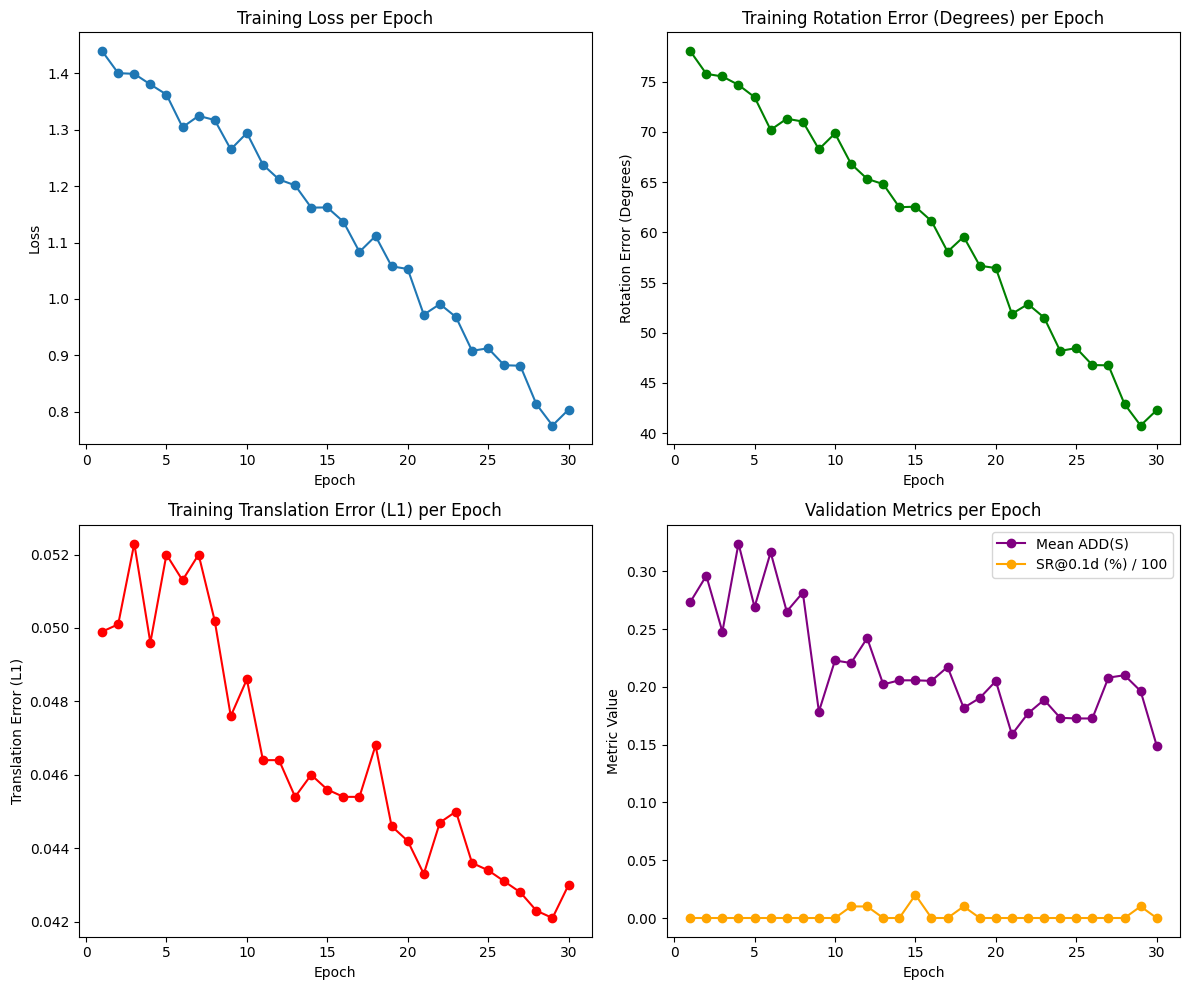

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import re

# Extract metrics from the output
output_30_epochs = """
[001/30] train_loss=1.4396 | train_rot_deg=78.05 | train_tL1=0.0499  ||  val(SMALL)_mean_ADD(S)=0.273233 | val(SMALL)_SR@0.1d=0.00%
[002/30] train_loss=1.4004 | train_rot_deg=75.78 | train_tL1=0.0501  ||  val(SMALL)_mean_ADD(S)=0.296062 | val(SMALL)_SR@0.1d=0.00%
[003/30] train_loss=1.3992 | train_rot_deg=75.52 | train_tL1=0.0523  ||  val(SMALL)_mean_ADD(S)=0.247668 | val(SMALL)_SR@0.1d=0.00%
[004/30] train_loss=1.3804 | train_rot_deg=74.68 | train_tL1=0.0496  ||  val(SMALL)_mean_ADD(S)=0.323917 | val(SMALL)_SR@0.1d=0.00%
[005/30] train_loss=1.3625 | train_rot_deg=73.46 | train_tL1=0.0520  ||  val(SMALL)_mean_ADD(S)=0.268995 | val(SMALL)_SR@0.1d=0.00%
[006/30] train_loss=1.3045 | train_rot_deg=70.20 | train_tL1=0.0513  ||  val(SMALL)_mean_ADD(S)=0.316319 | val(SMALL)_SR@0.1d=0.00%
[007/30] train_loss=1.3246 | train_rot_deg=71.31 | train_tL1=0.0520  ||  val(SMALL)_mean_ADD(S)=0.265124 | val(SMALL)_SR@0.1d=0.00%
[008/30] train_loss=1.3173 | train_rot_deg=71.03 | train_tL1=0.0502  ||  val(SMALL)_mean_ADD(S)=0.281533 | val(SMALL)_SR@0.1d=0.00%
[009/30] train_loss=1.2652 | train_rot_deg=68.27 | train_tL1=0.0476  ||  val(SMALL)_mean_ADD(S)=0.178501 | val(SMALL)_SR@0.1d=0.00%
[010/30] train_loss=1.2943 | train_rot_deg=69.85 | train_tL1=0.0486  ||  val(SMALL)_mean_ADD(S)=0.222777 | val(SMALL)_SR@0.1d=0.00%
[011/30] train_loss=1.2380 | train_rot_deg=66.81 | train_tL1=0.0464  ||  val(SMALL)_mean_ADD(S)=0.220565 | val(SMALL)_SR@0.1d=1.00%
[012/30] train_loss=1.2118 | train_rot_deg=65.32 | train_tL1=0.0464  ||  val(SMALL)_mean_ADD(S)=0.242094 | val(SMALL)_SR@0.1d=1.00%
[013/30] train_loss=1.2014 | train_rot_deg=64.80 | train_tL1=0.0454  ||  val(SMALL)_mean_ADD(S)=0.202086 | val(SMALL)_SR@0.1d=0.00%
[014/30] train_loss=1.1619 | train_rot_deg=62.50 | train_tL1=0.0460  ||  val(SMALL)_mean_ADD(S)=0.205617 | val(SMALL)_SR@0.1d=0.00%
[015/30] train_loss=1.1622 | train_rot_deg=62.55 | train_tL1=0.0456  ||  val(SMALL)_mean_ADD(S)=0.205590 | val(SMALL)_SR@0.1d=2.00%
[016/30] train_loss=1.1369 | train_rot_deg=61.12 | train_tL1=0.0454  ||  val(SMALL)_mean_ADD(S)=0.205158 | val(SMALL)_SR@0.1d=0.00%
[017/30] train_loss=1.0834 | train_rot_deg=58.07 | train_tL1=0.0454  ||  val(SMALL)_mean_ADD(S)=0.217153 | val(SMALL)_SR@0.1d=0.00%
[018/30] train_loss=1.1115 | train_rot_deg=59.56 | train_tL1=0.0468  ||  val(SMALL)_mean_ADD(S)=0.181803 | val(SMALL)_SR@0.1d=1.00%
[019/30] train_loss=1.0578 | train_rot_deg=56.67 | train_tL1=0.0446  ||  val(SMALL)_mean_ADD(S)=0.190296 | val(SMALL)_SR@0.1d=0.00%
[020/30] train_loss=1.0530 | train_rot_deg=56.44 | train_tL1=0.0442  ||  val(SMALL)_mean_ADD(S)=0.204976 | val(SMALL)_SR@0.1d=0.00%
[021/30] train_loss=0.9720 | train_rot_deg=51.88 | train_tL1=0.0433  ||  val(SMALL)_mean_ADD(S)=0.158752 | val(SMALL)_SR@0.1d=0.00%
[022/30] train_loss=0.9908 | train_rot_deg=52.85 | train_tL1=0.0447  ||  val(SMALL)_mean_ADD(S)=0.176990 | val(SMALL)_SR@0.1d=0.00%
[023/30] train_loss=0.9678 | train_rot_deg=51.51 | train_tL1=0.0450  ||  val(SMALL)_mean_ADD(S)=0.188734 | val(SMALL)_SR@0.1d=0.00%
[024/30] train_loss=0.9079 | train_rot_deg=48.19 | train_tL1=0.0436  ||  val(SMALL)_mean_ADD(S)=0.173158 | val(SMALL)_SR@0.1d=0.00%
[025/30] train_loss=0.9124 | train_rot_deg=48.47 | train_tL1=0.0434  ||  val(SMALL)_mean_ADD(S)=0.172628 | val(SMALL)_SR@0.1d=0.00%
[026/30] train_loss=0.8823 | train_rot_deg=46.78 | train_tL1=0.0431  ||  val(SMALL)_mean_ADD(S)=0.172598 | val(SMALL)_SR@0.1d=0.00%
[027/30] train_loss=0.8814 | train_rot_deg=46.75 | train_tL1=0.0428  ||  val(SMALL)_mean_ADD(S)=0.207928 | val(SMALL)_SR@0.1d=0.00%
[028/30] train_loss=0.8132 | train_rot_deg=42.90 | train_tL1=0.0423  ||  val(SMALL)_mean_ADD(S)=0.210028 | val(SMALL)_SR@0.1d=0.00%
[029/30] train_loss=0.7754 | train_rot_deg=40.76 | train_tL1=0.0421  ||  val(SMALL)_mean_ADD(S)=0.196347 | val(SMALL)_SR@0.1d=1.00%
[030/30] train_loss=0.8036 | train_rot_deg=42.29 | train_tL1=0.0430  ||  val(SMALL)_mean_ADD(S)=0.149189 | val(SMALL)_SR@0.1d=0.00%
"""
def visualize_resutls(output):
  epochs = []
  train_loss = []
  train_rot_deg = []
  train_tL1 = []
  val_mean_ADD = []
  val_SR = []

  for line in output.strip().split('\n'):
      match = re.search(r"\[(\d+)/\d+\] train_loss=([\d\.]+) \| train_rot_deg=([\d\.]+) \| train_tL1=([\d\.]+)  \|\|  val\(SMALL\)_mean_ADD\(S\)=([\d\.]+) \| val\(SMALL\)_SR@0.1d=([\d\.]+)%", line)
      if match:
          epochs.append(int(match.group(1)))
          train_loss.append(float(match.group(2)))
          train_rot_deg.append(float(match.group(3)))
          train_tL1.append(float(match.group(4)))
          val_mean_ADD.append(float(match.group(5)))
          val_SR.append(float(match.group(6)))

  metrics_df = pd.DataFrame({
      'Epoch': epochs,
      'Train Loss': train_loss,
      'Train Rot Deg': train_rot_deg,
      'Train tL1': train_tL1,
      'Val Mean ADD(S)': val_mean_ADD,
      'Val SR@0.1d (%)': val_SR
  })

  print(metrics_df)

  # Plotting the metrics
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

  axes[0, 0].plot(metrics_df['Epoch'], metrics_df['Train Loss'], marker='o')
  axes[0, 0].set_title('Training Loss per Epoch')
  axes[0, 0].set_xlabel('Epoch')
  axes[0, 0].set_ylabel('Loss')

  axes[0, 1].plot(metrics_df['Epoch'], metrics_df['Train Rot Deg'], marker='o', color='green')
  axes[0, 1].set_title('Training Rotation Error (Degrees) per Epoch')
  axes[0, 1].set_xlabel('Epoch')
  axes[0, 1].set_ylabel('Rotation Error (Degrees)')

  axes[1, 0].plot(metrics_df['Epoch'], metrics_df['Train tL1'], marker='o', color='red')
  axes[1, 0].set_title('Training Translation Error (L1) per Epoch')
  axes[1, 0].set_xlabel('Epoch')
  axes[1, 0].set_ylabel('Translation Error (L1)')

  axes[1, 1].plot(metrics_df['Epoch'], metrics_df['Val Mean ADD(S)'], marker='o', color='purple', label='Mean ADD(S)')
  axes[1, 1].plot(metrics_df['Epoch'], metrics_df['Val SR@0.1d (%)'] / 100, marker='o', color='orange', label='SR@0.1d (%) / 100') # Scale SR for better visualization
  axes[1, 1].set_title('Validation Metrics per Epoch')
  axes[1, 1].set_xlabel('Epoch')
  axes[1, 1].set_ylabel('Metric Value')
  axes[1, 1].legend()

  plt.tight_layout()
  plt.show()
visualize_resutls(output_30_epochs)

    Epoch  Train Loss  Train Rot Deg  Train tL1  Val Mean ADD(S)  \
0       1      1.7494          93.03     0.0819         0.287815   
1       2      1.6994          91.57     0.0659         0.154055   
2       3      1.6806          90.53     0.0653         0.225038   
3       4      1.6547          89.34     0.0618         0.294453   
4       5      1.6312          88.08     0.0609         0.152118   
5       6      1.5996          86.43     0.0591         0.164301   
6       7      1.5561          84.26     0.0552         0.155547   
7       8      1.4858          80.33     0.0541         0.284850   
8       9      1.4577          78.89     0.0522         0.257976   
9      10      1.4378          77.98     0.0495         0.218794   
10     11      1.4495          78.63     0.0497         0.137032   
11     12      1.4113          76.43     0.0498         0.158790   
12     13      1.4234          77.19     0.0490         0.146632   
13     14      1.3766          74.69     0.0469 

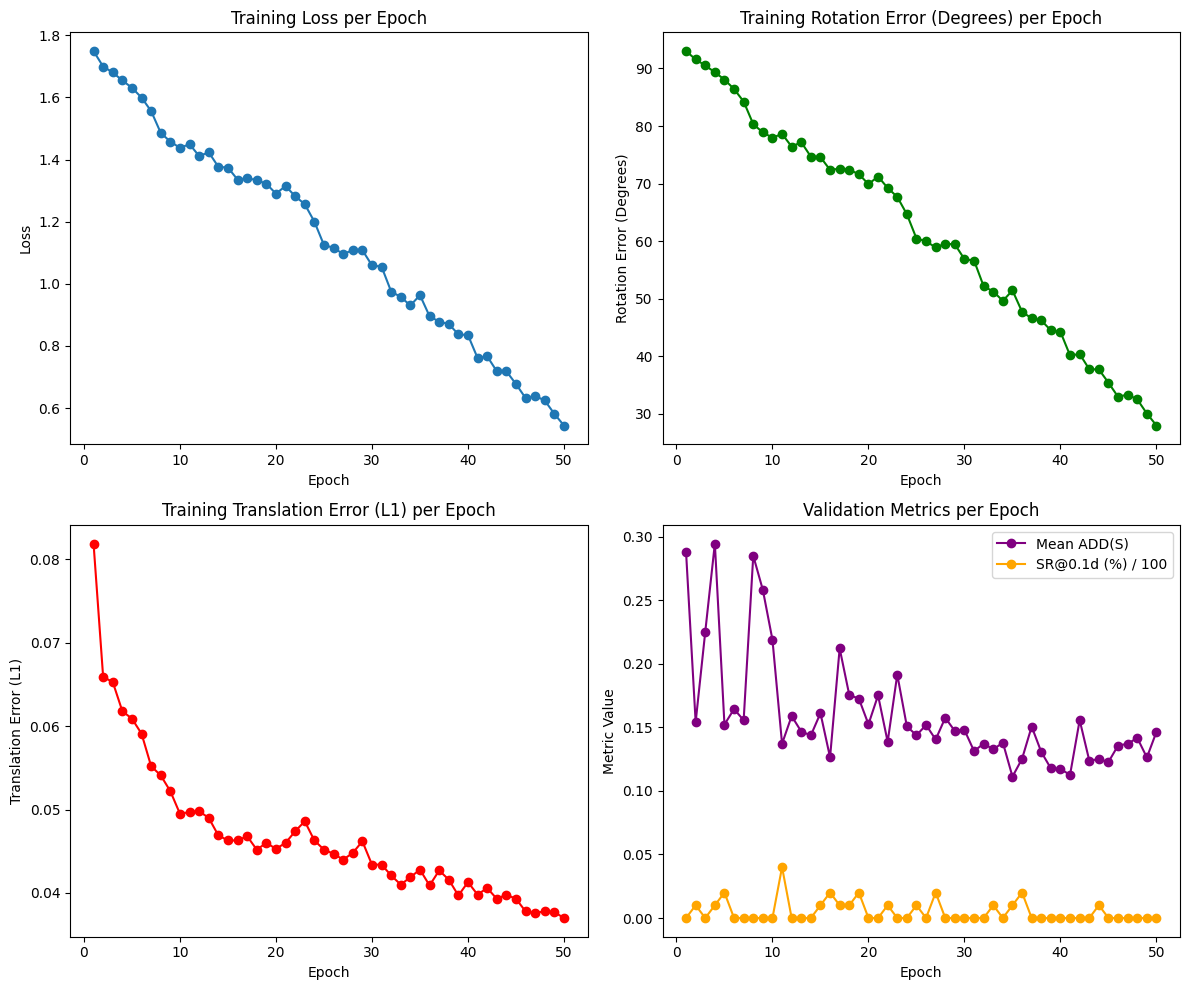

In [4]:
output_50_epochs= """
[001/50] train_loss=1.7494 | train_rot_deg=93.03 | train_tL1=0.0819  ||  val(SMALL)_mean_ADD(S)=0.287815 | val(SMALL)_SR@0.1d=0.00%
[002/50] train_loss=1.6994 | train_rot_deg=91.57 | train_tL1=0.0659  ||  val(SMALL)_mean_ADD(S)=0.154055 | val(SMALL)_SR@0.1d=1.00%
[003/50] train_loss=1.6806 | train_rot_deg=90.53 | train_tL1=0.0653  ||  val(SMALL)_mean_ADD(S)=0.225038 | val(SMALL)_SR@0.1d=0.00%
[004/50] train_loss=1.6547 | train_rot_deg=89.34 | train_tL1=0.0618  ||  val(SMALL)_mean_ADD(S)=0.294453 | val(SMALL)_SR@0.1d=1.00%
[005/50] train_loss=1.6312 | train_rot_deg=88.08 | train_tL1=0.0609  ||  val(SMALL)_mean_ADD(S)=0.152118 | val(SMALL)_SR@0.1d=2.00%
[006/50] train_loss=1.5996 | train_rot_deg=86.43 | train_tL1=0.0591  ||  val(SMALL)_mean_ADD(S)=0.164301 | val(SMALL)_SR@0.1d=0.00%
[007/50] train_loss=1.5561 | train_rot_deg=84.26 | train_tL1=0.0552  ||  val(SMALL)_mean_ADD(S)=0.155547 | val(SMALL)_SR@0.1d=0.00%
[008/50] train_loss=1.4858 | train_rot_deg=80.33 | train_tL1=0.0541  ||  val(SMALL)_mean_ADD(S)=0.284850 | val(SMALL)_SR@0.1d=0.00%
[009/50] train_loss=1.4577 | train_rot_deg=78.89 | train_tL1=0.0522  ||  val(SMALL)_mean_ADD(S)=0.257976 | val(SMALL)_SR@0.1d=0.00%
[010/50] train_loss=1.4378 | train_rot_deg=77.98 | train_tL1=0.0495  ||  val(SMALL)_mean_ADD(S)=0.218794 | val(SMALL)_SR@0.1d=0.00%
[011/50] train_loss=1.4495 | train_rot_deg=78.63 | train_tL1=0.0497  ||  val(SMALL)_mean_ADD(S)=0.137032 | val(SMALL)_SR@0.1d=4.00%
[012/50] train_loss=1.4113 | train_rot_deg=76.43 | train_tL1=0.0498  ||  val(SMALL)_mean_ADD(S)=0.158790 | val(SMALL)_SR@0.1d=0.00%
[013/50] train_loss=1.4234 | train_rot_deg=77.19 | train_tL1=0.0490  ||  val(SMALL)_mean_ADD(S)=0.146632 | val(SMALL)_SR@0.1d=0.00%
[014/50] train_loss=1.3766 | train_rot_deg=74.69 | train_tL1=0.0469  ||  val(SMALL)_mean_ADD(S)=0.143619 | val(SMALL)_SR@0.1d=0.00%
[015/50] train_loss=1.3741 | train_rot_deg=74.60 | train_tL1=0.0463  ||  val(SMALL)_mean_ADD(S)=0.161085 | val(SMALL)_SR@0.1d=1.00%
[016/50] train_loss=1.3355 | train_rot_deg=72.39 | train_tL1=0.0463  ||  val(SMALL)_mean_ADD(S)=0.126364 | val(SMALL)_SR@0.1d=2.00%
[017/50] train_loss=1.3396 | train_rot_deg=72.59 | train_tL1=0.0468  ||  val(SMALL)_mean_ADD(S)=0.212003 | val(SMALL)_SR@0.1d=1.00%
[018/50] train_loss=1.3341 | train_rot_deg=72.41 | train_tL1=0.0452  ||  val(SMALL)_mean_ADD(S)=0.175434 | val(SMALL)_SR@0.1d=1.00%
[019/50] train_loss=1.3218 | train_rot_deg=71.64 | train_tL1=0.0460  ||  val(SMALL)_mean_ADD(S)=0.172510 | val(SMALL)_SR@0.1d=2.00%
[020/50] train_loss=1.2904 | train_rot_deg=69.91 | train_tL1=0.0453  ||  val(SMALL)_mean_ADD(S)=0.152342 | val(SMALL)_SR@0.1d=0.00%
[021/50] train_loss=1.3147 | train_rot_deg=71.23 | train_tL1=0.0460  ||  val(SMALL)_mean_ADD(S)=0.175099 | val(SMALL)_SR@0.1d=0.00%
[022/50] train_loss=1.2820 | train_rot_deg=69.25 | train_tL1=0.0474  ||  val(SMALL)_mean_ADD(S)=0.138535 | val(SMALL)_SR@0.1d=1.00%
[023/50] train_loss=1.2563 | train_rot_deg=67.69 | train_tL1=0.0486  ||  val(SMALL)_mean_ADD(S)=0.191460 | val(SMALL)_SR@0.1d=0.00%
[024/50] train_loss=1.2002 | train_rot_deg=64.68 | train_tL1=0.0463  ||  val(SMALL)_mean_ADD(S)=0.150699 | val(SMALL)_SR@0.1d=0.00%
[025/50] train_loss=1.1248 | train_rot_deg=60.46 | train_tL1=0.0452  ||  val(SMALL)_mean_ADD(S)=0.143676 | val(SMALL)_SR@0.1d=1.00%
[026/50] train_loss=1.1159 | train_rot_deg=59.99 | train_tL1=0.0447  ||  val(SMALL)_mean_ADD(S)=0.151784 | val(SMALL)_SR@0.1d=0.00%
[027/50] train_loss=1.0958 | train_rot_deg=58.90 | train_tL1=0.0440  ||  val(SMALL)_mean_ADD(S)=0.140369 | val(SMALL)_SR@0.1d=2.00%
[028/50] train_loss=1.1085 | train_rot_deg=59.55 | train_tL1=0.0448  ||  val(SMALL)_mean_ADD(S)=0.157443 | val(SMALL)_SR@0.1d=0.00%
[029/50] train_loss=1.1084 | train_rot_deg=59.45 | train_tL1=0.0462  ||  val(SMALL)_mean_ADD(S)=0.147040 | val(SMALL)_SR@0.1d=0.00%
[030/50] train_loss=1.0593 | train_rot_deg=56.87 | train_tL1=0.0434  ||  val(SMALL)_mean_ADD(S)=0.147816 | val(SMALL)_SR@0.1d=0.00%
[031/50] train_loss=1.0551 | train_rot_deg=56.63 | train_tL1=0.0434  ||  val(SMALL)_mean_ADD(S)=0.131262 | val(SMALL)_SR@0.1d=0.00%
[032/50] train_loss=0.9750 | train_rot_deg=52.16 | train_tL1=0.0421  ||  val(SMALL)_mean_ADD(S)=0.137108 | val(SMALL)_SR@0.1d=0.00%
[033/50] train_loss=0.9575 | train_rot_deg=51.25 | train_tL1=0.0410  ||  val(SMALL)_mean_ADD(S)=0.132591 | val(SMALL)_SR@0.1d=1.00%
[034/50] train_loss=0.9302 | train_rot_deg=49.63 | train_tL1=0.0419  ||  val(SMALL)_mean_ADD(S)=0.137913 | val(SMALL)_SR@0.1d=0.00%
[035/50] train_loss=0.9634 | train_rot_deg=51.44 | train_tL1=0.0428  ||  val(SMALL)_mean_ADD(S)=0.111161 | val(SMALL)_SR@0.1d=1.00%
[036/50] train_loss=0.8956 | train_rot_deg=47.73 | train_tL1=0.0409  ||  val(SMALL)_mean_ADD(S)=0.125188 | val(SMALL)_SR@0.1d=2.00%
[037/50] train_loss=0.8780 | train_rot_deg=46.58 | train_tL1=0.0427  ||  val(SMALL)_mean_ADD(S)=0.150538 | val(SMALL)_SR@0.1d=0.00%
[038/50] train_loss=0.8705 | train_rot_deg=46.23 | train_tL1=0.0416  ||  val(SMALL)_mean_ADD(S)=0.130561 | val(SMALL)_SR@0.1d=0.00%
[039/50] train_loss=0.8372 | train_rot_deg=44.50 | train_tL1=0.0397  ||  val(SMALL)_mean_ADD(S)=0.117634 | val(SMALL)_SR@0.1d=0.00%
[040/50] train_loss=0.8348 | train_rot_deg=44.23 | train_tL1=0.0413  ||  val(SMALL)_mean_ADD(S)=0.116985 | val(SMALL)_SR@0.1d=0.00%
[041/50] train_loss=0.7610 | train_rot_deg=40.14 | train_tL1=0.0398  ||  val(SMALL)_mean_ADD(S)=0.112679 | val(SMALL)_SR@0.1d=0.00%
[042/50] train_loss=0.7666 | train_rot_deg=40.39 | train_tL1=0.0406  ||  val(SMALL)_mean_ADD(S)=0.155582 | val(SMALL)_SR@0.1d=0.00%
[043/50] train_loss=0.7185 | train_rot_deg=37.75 | train_tL1=0.0393  ||  val(SMALL)_mean_ADD(S)=0.123838 | val(SMALL)_SR@0.1d=0.00%
[044/50] train_loss=0.7184 | train_rot_deg=37.71 | train_tL1=0.0398  ||  val(SMALL)_mean_ADD(S)=0.124834 | val(SMALL)_SR@0.1d=1.00%
[045/50] train_loss=0.6772 | train_rot_deg=35.40 | train_tL1=0.0393  ||  val(SMALL)_mean_ADD(S)=0.122707 | val(SMALL)_SR@0.1d=0.00%
[046/50] train_loss=0.6321 | train_rot_deg=32.95 | train_tL1=0.0378  ||  val(SMALL)_mean_ADD(S)=0.135643 | val(SMALL)_SR@0.1d=0.00%
[047/50] train_loss=0.6387 | train_rot_deg=33.35 | train_tL1=0.0376  ||  val(SMALL)_mean_ADD(S)=0.136962 | val(SMALL)_SR@0.1d=0.00%
[048/50] train_loss=0.6242 | train_rot_deg=32.50 | train_tL1=0.0378  ||  val(SMALL)_mean_ADD(S)=0.141644 | val(SMALL)_SR@0.1d=0.00%
[049/50] train_loss=0.5811 | train_rot_deg=30.05 | train_tL1=0.0377  ||  val(SMALL)_mean_ADD(S)=0.126229 | val(SMALL)_SR@0.1d=0.00%
[050/50] train_loss=0.5437 | train_rot_deg=27.97 | train_tL1=0.0370  ||  val(SMALL)_mean_ADD(S)=0.146439 | val(SMALL)_SR@0.1d=0.00%
"""
visualize_resutls(output)

Let's break down what these metrics mean:

*   **Train Loss:** This is the value of the loss function during training for each epoch. The loss function is a combination of the rotation loss (geodesic distance between predicted and ground truth rotations) and translation loss (L1 distance between predicted and ground truth translations). A decreasing training loss generally indicates that the model is learning.

*   **Train Rot Deg:** This is the average geodesic rotation error in degrees on the training data for each epoch. A lower value indicates better rotation predictions.

*   **Train tL1:** This is the average L1 translation error on the training data for each epoch. A lower value indicates better translation predictions.

*   **Val Mean ADD(S):** This is the mean Average Distance of Model Points (Symmetric) on the validation set. It measures the average distance between the predicted and ground truth model points. For symmetric objects, it uses the closest point distance (ADD-S), and for non-symmetric objects, it uses the direct point distance (ADD). A lower value indicates better pose accuracy.

*   **Val SR@0.1d (%):** This is the Success Rate at 0.1 times the object's diameter on the validation set. It's a common metric for 6D object pose estimation. A prediction is considered successful if the ADD(S) error is less than 10% of the object's diameter. A higher percentage indicates better performance.

Looking at the plots, we can observe how each metric changes over the 4 epochs. Ideally, you would want to see the training loss, rotation error, and translation error decrease, while the validation metrics (Mean ADD(S) and SR@0.1d) improve (Mean ADD(S) decreasing, SR@0.1d increasing).

Based on the current plots, after 4 epochs on the small dataset:
*   Training loss, rotation error, and translation error show some fluctuation but generally decrease.
*   The validation mean ADD(S) also fluctuates.
*   The validation SR@0.1d remains at 0.00%, suggesting that none of the predictions on the small validation subset were within the 0.1 times object diameter threshold.

This indicates that the model is starting to learn, but likely needs more training epochs on the full dataset and potentially hyperparameter tuning to achieve better performance on the validation set and improve the SR@0.1d metric.

In [ ]:
# === Load trained FormerPose checkpoint ===
net_eval = FormerPose(
    img_ch=3,
    dim=CFG["hidden"],
    heads=4,
    scales=CFG["rgb_scales"],
    dropkey=CFG["dropkey_p"]
).to(DEVICE)

ckpt_path = os.path.join(CFG["save_dir"], "formerpose_ep4.pth")
state = torch.load(ckpt_path, map_location=DEVICE)
net_eval.load_state_dict(state)
net_eval.eval()

print(f"✅ Loaded FormerPose weights from {ckpt_path}")


✅ Loaded FormerPose weights from /content/ckpts/formerpose_ep4.pth


In [ ]:
metrics = validate_metrics(net_eval, va_small, MODEL_BANK_FAST, SYM_IDS, OBJ_DIAM_FAST)
print("📊 Evaluation Results on LINEMOD Subset")
print(f"Mean ADD(S): {metrics['mean_ADD(S)']:.6f} m")
print(f"SR@0.1d: {metrics['SR@0.1d(%)']:.2f}%")


📊 Evaluation Results on LINEMOD Subset
Mean ADD(S): 0.394734 m
SR@0.1d: 0.00%


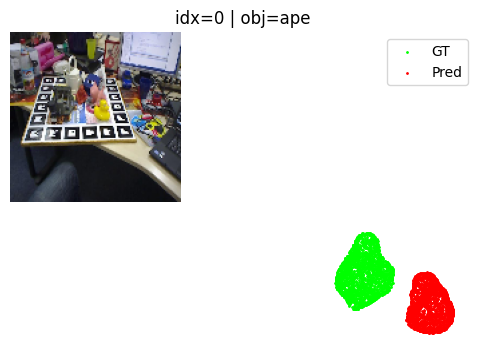

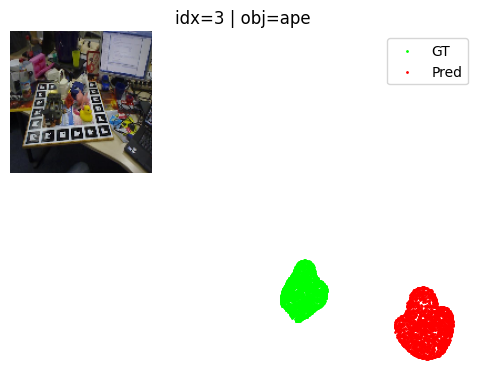

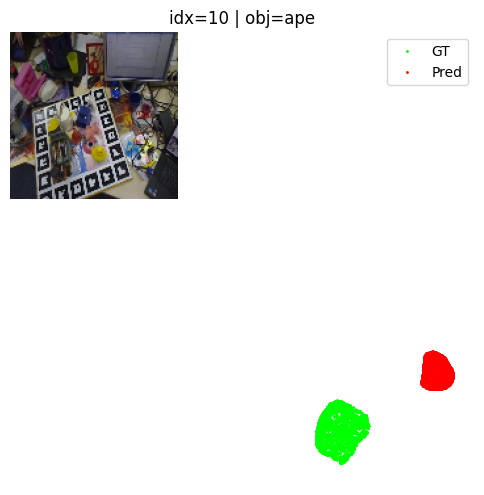

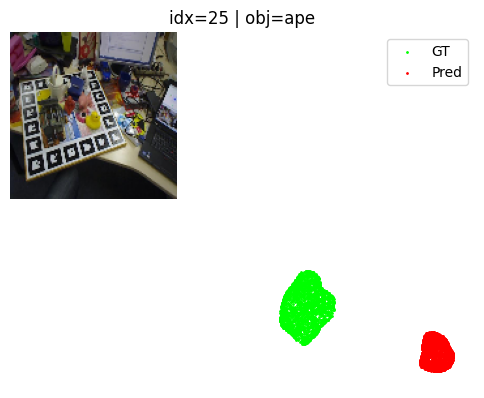

In [ ]:
# === FormerPose visualization for your dataset keys ===
import torch, numpy as np, matplotlib.pyplot as plt

@torch.no_grad()
def visualize_prediction_sample(model, sample, model_bank, dataset=None, K=None, title=""):
    # Tensors from your sample
    rgb = sample["rgb"].unsqueeze(0).to(DEVICE)            # (1,3,H,W)
    pc  = sample["pc"].unsqueeze(0).to(DEVICE)             # (1,N,3)
    Rgt = sample["R_gt"].cpu().numpy()                     # (3,3)
    tgt = sample["t_gt"].cpu().numpy()                     # (3,)
    obj_id = int(sample["obj_id"].item())
    obj_name = sample.get("object", f"id_{obj_id}")

    # Predict
    rot6d, t = model(rgb, pc)
    Rpr = rot6d_to_mat(rot6d).float()[0].cpu().numpy()     # (3,3)
    tpr = t.float()[0].cpu().numpy()                       # (3,)

    # Grab model points (XYZ only)
    mp = model_bank[obj_id]
    if mp.shape[1] > 3: mp = mp[:, :3]

    # Intrinsics: try dataset.K, else default LINEMOD K
    if K is None:
        K = getattr(dataset, "K", None) if dataset is not None else None
    if K is None:
        K = np.array([[572.4114, 0.0, 325.2611],
                      [0.0, 573.57043, 242.04899],
                      [0.0, 0.0, 1.0]], dtype=np.float32)

    def project_pts(pts, R, T, K):
        P = (R @ pts.T).T + T
        uv = (K @ P.T).T
        uv = uv[:, :2] / np.clip(uv[:, 2:3], 1e-6, None)
        return uv

    uv_gt = project_pts(mp, Rgt, tgt, K)
    uv_pr = project_pts(mp, Rpr, tpr, K)

    # Draw
    img = (sample["rgb"].permute(1,2,0).cpu().numpy() * 255).astype(np.uint8).copy()
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(img)
    ax.scatter(uv_gt[:,0], uv_gt[:,1], s=1, c='lime', label="GT")
    ax.scatter(uv_pr[:,0], uv_pr[:,1], s=1, c='red',  label="Pred")
    ax.set_title(title or f"{obj_name} — GT (green) vs Pred (red)")
    ax.axis("off"); ax.legend()
    plt.show()

@torch.no_grad()
def visualize_batch(model, dataset, model_bank, indices=(0,500)):
    for i in indices:
        s = dataset[i]
        visualize_prediction_sample(model, s, model_bank, dataset=dataset, title=f"idx={i} | obj={s.get('object','?')}")

# e.g.:
visualize_batch(net_eval, va.dataset, MODEL_BANK_FAST, indices=(0,3,10,25))
